In [1]:
pip install gensim

In [2]:
#%pip uninstall -y numpy
#%pip install pandas gensim

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
from sklearn.utils.class_weight import compute_class_weight
import re
import string
import spacy
import wordcloud
from wordcloud import WordCloud,STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from hyperopt import hp
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers


In [6]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
nlp=spacy.load('en_core_web_sm',disable=['parser','ner'])
stopwords=set(stopwords.words('english'))

In [8]:
df=pd.read_csv('/content/laptops_dataset_final_600.csv')

In [9]:
df

,product_name,overall_rating,no_ratings,no_reviews,rating,title,review
0,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Perfect product!,"Loved it, it's my first MacBook that I earned ..."
1,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Fabulous!,Battery lasted longer than my first relationsh...
2,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Fabulous!,Such a great deal.. very happy with the perfor...
3,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,4,Delightful,"Awesome build quality and very good display, b..."
4,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Awesome,When i ordered and came to know about seller r...
...,...,...,...,...,...,...,...
24108,MSI Modern 14 Intel Core i5 13th Gen 1335U - (...,4.3,156,24,5,Perfect product!,MSI Laptop is high performance and the best. c...
24109,MSI Modern 14 Intel Core i5 13th Gen 1335U - (...,4.3,156,24,5,Perfect product!,Excellent performance best laptop.
24110,MSI Modern 14 Intel Core i5 13th Gen 1335U - (...,4.3,156,24,4,"Good product, Lacks features.",Decent battery life. Exceptional build quality...
24111,Lenovo IdeaPad 5 2-in-1 WUXGA IPS AMD Ryzen 7 ...,4.4,7,2,3,Nice,The product does not support facial recognitio...


In [10]:
df.isnull().sum()

,0
product_name,0
overall_rating,0
no_ratings,0
no_reviews,0
rating,0
title,0
review,0


In [11]:
df.head()

,product_name,overall_rating,no_ratings,no_reviews,rating,title,review
0,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Perfect product!,"Loved it, it's my first MacBook that I earned ..."
1,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Fabulous!,Battery lasted longer than my first relationsh...
2,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Fabulous!,Such a great deal.. very happy with the perfor...
3,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,4,Delightful,"Awesome build quality and very good display, b..."
4,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Awesome,When i ordered and came to know about seller r...


In [12]:
df.describe()

,overall_rating,rating
count,24113.000000,24113.000000
mean,4.186273,4.214573
std,0.228392,1.184845
min,3.300000,1.000000
25%,4.100000,4.000000
50%,4.200000,5.000000
75%,4.300000,5.000000
max,5.000000,5.000000


In [13]:
print('Total Duplicates',df.duplicated().sum())

Total Duplicates 7122


In [14]:
df=df.drop_duplicates()

In [15]:
df['Brand Name']=df['product_name'].apply(lambda x:re.match(r'^\w+',x).group() if re.match(r'^\w+',x) else None)

/tmp/ipython-input-15-1765750015.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Brand Name']=df['product_name'].apply(lambda x:re.match(r'^\w+',x).group() if re.match(r'^\w+',x) else None)


In [16]:
def clean_review_count(value):
  if pd.isna(value):  # if value is missing or Nan
    return 0
  if isinstance(value,(int,float)): #convert float into int
    return int(value)
  return int(str(value).replace(',', ''))

In [17]:
df['no_ratings']=df['no_ratings'].apply(clean_review_count)
df['no_reviews']=df['no_reviews'].apply(clean_review_count)

/tmp/ipython-input-17-1884397090.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['no_ratings']=df['no_ratings'].apply(clean_review_count)
/tmp/ipython-input-17-1884397090.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['no_reviews']=df['no_reviews'].apply(clean_review_count)


In [18]:
df.head()

,product_name,overall_rating,no_ratings,no_reviews,rating,title,review,Brand Name
0,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,5,Perfect product!,"Loved it, it's my first MacBook that I earned ...",Apple
1,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,5,Fabulous!,Battery lasted longer than my first relationsh...,Apple
2,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,5,Fabulous!,Such a great deal.. very happy with the perfor...,Apple
3,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,4,Delightful,"Awesome build quality and very good display, b...",Apple
4,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,15210,900,5,Awesome,When i ordered and came to know about seller r...,Apple


In [19]:
df['confidence']=np.log1p(df['no_reviews']) * 0.3 + np.log1p(df['no_ratings']) * 0.2

/tmp/ipython-input-19-3433320289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['confidence']=np.log1p(df['no_reviews']) * 0.3 + np.log1p(df['no_ratings']) * 0.2


In [20]:
df['confidence'] = (df['confidence'] - df['confidence'].min()) / (df['confidence'].max() - df['confidence'].min())
#Converts all confidence values to be between 0 and 1.

#0 means lowest confidence, 1 means highest confidence.

/tmp/ipython-input-20-3713714012.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['confidence'] = (df['confidence'] - df['confidence'].min()) / (df['confidence'].max() - df['confidence'].min())


In [21]:
df['adjusted_threshold'] = 3.5 + (df['overall_rating'] - 3.5) * df['confidence']
#If we trust the product (high confidence), we let its rating influence the score more.

#If we don’t trust it (low confidence), we stick to the safe middle (3.5).

/tmp/ipython-input-21-1307508005.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['adjusted_threshold'] = 3.5 + (df['overall_rating'] - 3.5) * df['confidence']


In [22]:
df['sentiment'] = np.where(
    df['rating'] >= df['adjusted_threshold'],
    'Positive',
    np.where(
        df['rating'] <= (df['adjusted_threshold'] - 1.5),
        'Negative',
        'Neutral'
    )
)

/tmp/ipython-input-22-1479511409.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = np.where(


In [23]:
sentiment_count=df['sentiment'].value_counts().reset_index()
sentiment_count.columns=['Sentiment','Count']

styled_value_counts_s = (
    sentiment_count.style
    .bar(subset=['Count'], color='#d65f5f')  # Red bars for counts
)

styled_value_counts_s

,Sentiment,Count
0,Positive,11948
1,Neutral,3297
2,Negative,1746


In [24]:
brand_count=df['Brand Name'].value_counts().reset_index()
brand_count.columns=['Brand Name','Count']

styled_value_counts_brand = (
    brand_count.style
    .bar(subset=['Count'], color='#5fba7d')  # Red bars for counts
)


styled_value_counts_brand

,Brand Name,Count
0,HP,4387
1,ASUS,3046
2,Acer,2810
3,Lenovo,2387
4,MSI,1451
5,DELL,742
6,Infinix,608
7,SAMSUNG,335
8,CHUWI,282
9,Apple,232


/tmp/ipython-input-25-473716702.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df,x='Brand Name',palette='viridis')


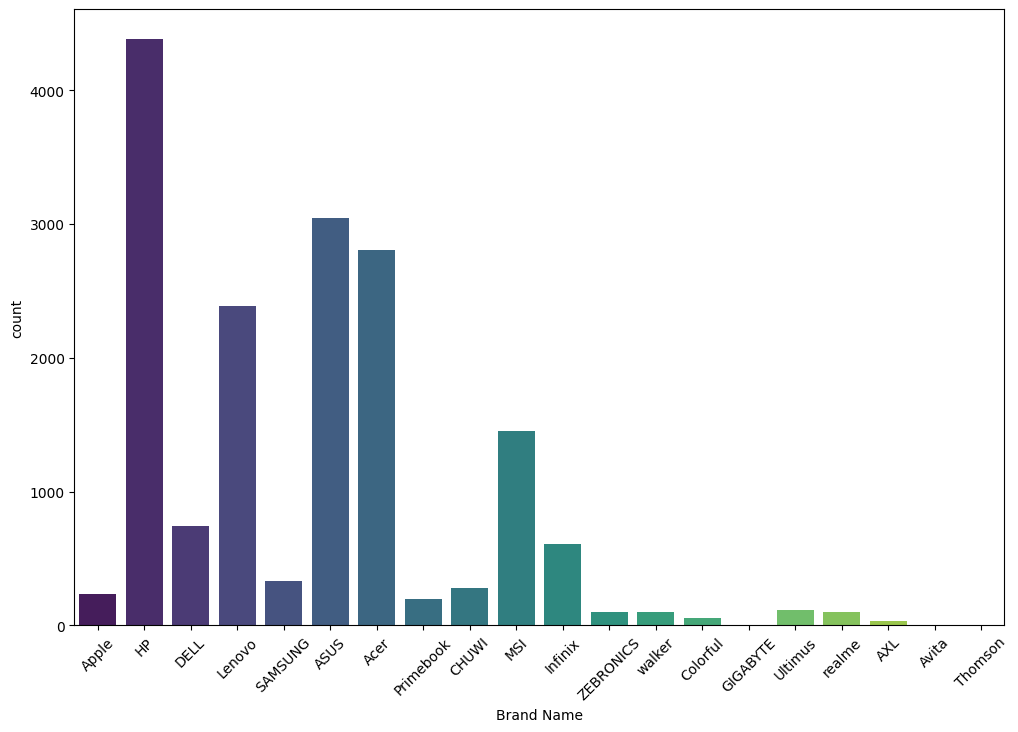

In [25]:
plt.figure(figsize=(12,8))
sns.countplot(data=df,x='Brand Name',palette='viridis')
plt.xticks(rotation=45)
plt.show()

In [26]:
sentiment_map = {
    'Positive': 1,
    'Neutral': 2,
    'Negative': 0
}
df['sentiment_num'] = df['sentiment'].map(sentiment_map)

/tmp/ipython-input-26-2005139448.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_num'] = df['sentiment'].map(sentiment_map)


In [27]:
negative_stopwords=set(STOPWORDS).union({'good', 'laptop', 'computer', 'product', 'will', 'laptops', 'go', 'now'  # Explicitly add  stopwords
})

In [28]:
text=" ".join(df[df['sentiment']=='Positive']['review'])

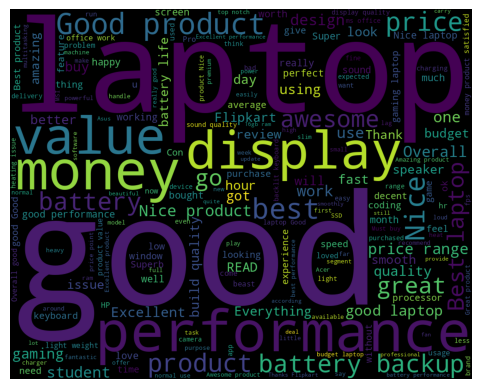

In [29]:
wc=WordCloud(width=1000,height=800).generate(text)
plt.imshow(wc)
plt.axis('off')
plt.show()

In [30]:
text1=" ".join(df[df['sentiment']=="Negative"]['review'])

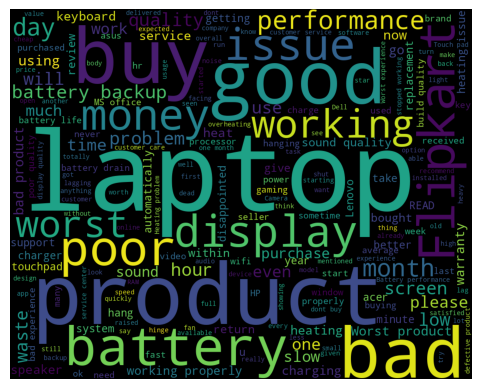

In [31]:
wc1=WordCloud(width=1000,height=800).generate(text1)
plt.imshow(wc1)
plt.axis('off')
plt.show()

In [32]:
def clean_text(text):
  text=str(text).lower()
  text=re.sub(r'a-zA-Z\s','',text) #special chars
  text=re.sub(r' \s+',' ',text).strip()
  tokens = word_tokenize(text)
  doc = nlp(" ".join(tokens))
  lemmas = [token.lemma_ for token in doc if not token.is_punct and token.lemma_ not in stopwords]

  return " ".join(lemma for lemma in lemmas if len(lemma) > 2)

In [33]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [34]:
#stopwords=set(stopwords.words('english'))

In [35]:
df['preprocessed_text']=df['review'].apply(clean_text)

/tmp/ipython-input-35-2494039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preprocessed_text']=df['review'].apply(clean_text)


In [36]:
X=df['preprocessed_text']
y=df['sentiment_num']

In [37]:
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)#If you have many more samples of one class than another (say, 90% class 0, 10% class 1), this helps give the rare class more importance during training.
class_weight_dict = dict(zip(np.unique(y), class_weights))  #This line creates a dictionary where each class label maps to its computed weight.
print("Class Weights:", class_weight_dict)


Class Weights: {0: 3.243795341733486, 1: 0.4740263363463899, 2: 1.7178242847032656}


# Embedding
Post preprocessing of the data, what we essentially derive are tokens, which are words reduced to their root forms. But machine itself cannot process these text data. So, what's the solution??

We represent each of these tokens in an n-dimensional vector space, with the logic that words with similar meanings are closer together in terms of distance in the space, whereas words that are further are less similar relatively.

While modern architectures like BERT having their own embedding processing (using input embedding, psoitional embedding and segment wise embedding), Word2Vec is a relatively simpler way of embedding words into a vector space.

Word2Vec helps capture semantic relationships between words, i.e relationships like

"King" - "Man" + "Woman" = "Queen"

Like all good things, however, there are drawbacks to this:

Word2Vec fails to capture multiple meanings of same word
For example,

Sentence 1: I am going to the "bank" to deposit some money Sentence 2: The cow was roaming past the river "bank"

Word2Vec also fails to capture the contextual understanding of words with regards to the dataset
For example,

Sentence: The dog did not cross the road because "it" was afraid

Here, Word2Vec would fail to understand what the word "it" refers to

In [38]:
sentences=[text.split() for text in X]
wv2_model=Word2Vec(sentences,
                   vector_size=300,
                   window=5,
                   min_count=3, #ignores all words that appear less than 3 times in the corpus.
                   workers=4,
                   epochs=30)
#The model learns how words are used in context and creates numerical vector representations of words that capture their meaning.

tokenizer=Tokenizer()
tokenizer.fit_on_texts(X)  #To convert text to numbers for the model
vocab_size = len(tokenizer.word_index) + 1   #An embedding is a special type of layer (or model) that converts words into meaningful numerical vectors.

#Each word becomes a vector (e.g., a list of 100 or 300 numbers), and words that appear in similar contexts will have similar vectors.



In [39]:
#Convert text to sequences
X_seq = tokenizer.texts_to_sequences(X)
max_len = max(len(x) for x in X_seq)
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    if word in wv2_model.wv:
        embedding_matrix[i] = wv2_model.wv[word]

In [40]:
X_train,X_test,y_train,y_test=train_test_split(X_pad,y,test_size=0.2,random_state=42)

In [41]:
def build_lstm(lstm_units=128, dropout_rate=0.4, l2_reg=0.01):
    model = Sequential([
        Embedding(vocab_size, 300,
                 weights=[embedding_matrix],
                 trainable=False),
        Bidirectional(LSTM(lstm_units,
                         return_sequences=True,
                         kernel_regularizer=l2(l2_reg))),
        Dropout(dropout_rate),
        Bidirectional(LSTM(lstm_units//2)),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model


In [42]:
model = build_lstm()

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    class_weight=class_weight_dict
)
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred,
                          target_names=['Negative', 'Neutral', 'Positive']))

Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 148s 654ms/step - accuracy: 0.6091 - loss: 3.5325 - val_accuracy: 0.7140 - val_loss: 0.8156
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 150s 695ms/step - accuracy: 0.6833 - loss: 0.7998 - val_accuracy: 0.6564 - val_loss: 0.8273
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 205s 707ms/step - accuracy: 0.6730 - loss: 0.7844 - val_accuracy: 0.6796 - val_loss: 0.7868
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 188s 641ms/step - accuracy: 0.6854 - loss: 0.7641 - val_accuracy: 0.6702 - val_loss: 0.8246
Epoch 5/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 147s 690ms/step - accuracy: 0.6873 - loss: 0.7635 - val_accuracy: 0.6905 - val_loss: 0.8182
Epoch 6/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 140s 656ms/step - accuracy: 0.6799 - loss: 0.7761 - val_accuracy: 0.7146 - val_loss: 0.7885
Epoch 7/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 150s 697ms/step - accuracy: 0.7035 - loss: 0.7425 - val_accuracy: 0.6999 - val_loss: 0.7788
Epoch 8/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 148s 695ms/step - accuracy: 